   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==12

Saving archive.zip to archive (1).zip
archive (1).zip extracted successfully!


INFO:language_tool_python.download_lt:Unzipping /tmp/tmpovfd747_.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-6.4.zip to /root/.cache/language_tool_python.
Correcting Text: 100%|██████████| 100/100 [26:51<00:00, 16.11s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy: 0.99
Recall: 0.98

Confusion Matrix:
[[999   1]
 [ 18 982]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1000
           1       1.00      0.98      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



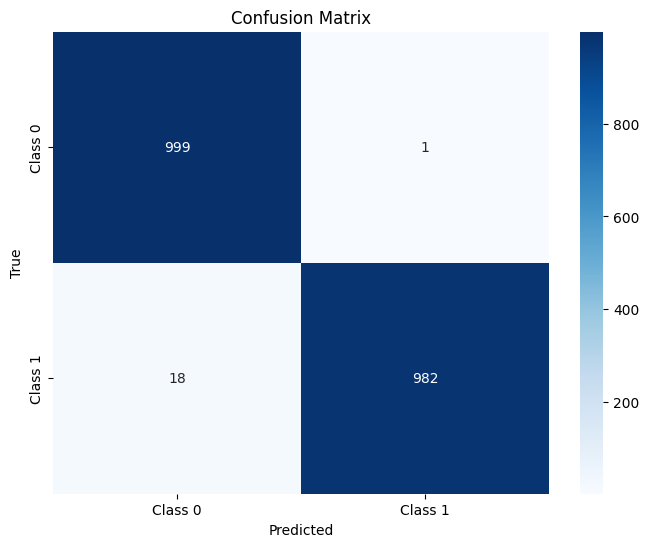

In [ ]:
# Install necessary libraries
!pip install -q kaggle datasets language-tool-python tqdm matplotlib seaborn

# Upload the dataset manually
from google.colab import files
import zipfile
import os

# Ask user to upload the dataset zip file
print("Please upload your dataset ZIP file:")
uploaded = files.upload()

# Extract the ZIP file
for filename in uploaded.keys():
    if filename.endswith(".zip"):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall()  # Extract in current directory
        print(f"{filename} extracted successfully!")

# Import necessary libraries
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import language_tool_python
import pickle

# Load and limit the dataset
df = pd.read_csv('train_v2_drcat_02.csv')

# Limit to 1,000 samples per label
df_0 = df[df['label'] == 0].sample(5000, random_state=42)
df_1 = df[df['label'] == 1].sample(5000, random_state=42)
df = pd.concat([df_0, df_1]).reset_index(drop=True)

# Preprocess the dataset
df['text'] = df['text'].str.replace('\n', '', regex=False)

# Initialize LanguageTool
tool = language_tool_python.LanguageTool('en-US')

# Function to correct sentences using LanguageTool
def correct_sentence(sentence):
    return tool.correct(sentence)

# Batch processing with progress bar
def correct_df_in_batches(df, batch_size=100):
    corrected_text = []
    for i in tqdm(range(0, len(df), batch_size), desc="Correcting Text"):
        batch = df['text'].iloc[i:i + batch_size]
        corrected_batch = [correct_sentence(sentence) for sentence in batch]
        corrected_text.extend(corrected_batch)
    df['text'] = corrected_text

# Correct the training data in batches
correct_df_in_batches(df)

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 5), sublinear_tf=True)
X = vectorizer.fit_transform(df['text'])

# Label extraction
y = df['label']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models
lr_model = LogisticRegression()
sgd_model = SGDClassifier(max_iter=5000, tol=1e-3, loss="modified_huber")

# Create the ensemble model
ensemble = VotingClassifier(estimators=[('lr', lr_model), ('sgd', sgd_model)], weights=[0.01, 0.99], voting='soft')

# Train the model
ensemble.fit(X_train, y_train)


# Save the vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save the trained model
with open('ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble, f)

# Download the files from Colab
from google.colab import files
files.download('vectorizer.pkl')
files.download('ensemble_model.pkl')

# Test the model on unseen data
y_pred = ensemble.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
 # Step 1: Upload vectorizer.pkl and dataset file manually
from google.colab import files
import pickle
import pandas as pd

print("Please upload your 'vectorizer.pkl' file:")
uploaded_vectorizer = files.upload()  # Manually upload vectorizer.pkl

print("Please upload your 'train_v2_drcat_02.csv' dataset file:")
uploaded_dataset = files.upload()  # Manually upload dataset CSV file

# Step 2: Load the uploaded vectorizer
vectorizer_filename = 'vectorizer.pkl'
with open(vectorizer_filename, 'rb') as f:
    vectorizer = pickle.load(f)

print("Vectorizer loaded successfully!")

# Step 3: Load a small sample of the uploaded dataset
dataset_filename = 'train_v2_drcat_02.csv'
df_sample = pd.read_csv(dataset_filename).head(5)  # Take first 5 rows for testing

# Step 4: Print raw text before feature extraction
print("\nBefore Feature Extraction:")
for i, text in enumerate(df_sample['text'], 1):
    print(f"{i}. {text}")

# Step 5: Apply TF-IDF transformation
X_sample = vectorizer.transform(df_sample['text'])

# Step 6: Print after feature extraction (converted to an array for readability)
print("\nAfter Feature Extraction (TF-IDF):")
print(X_sample.toarray())  # Convert sparse matrix to dense format
print.show(10)

Please upload your 'vectorizer.pkl' file:


Saving vectorizer.pkl to vectorizer.pkl
Please upload your 'train_v2_drcat_02.csv' dataset file:


Saving train_v2_drcat_02.csv to train_v2_drcat_02.csv
Vectorizer loaded successfully!

Before Feature Extraction:
1. Phones

Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.

When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.

Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Proble

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
scores = cross_val_score(ensemble, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean()}")


Cross-Validation Scores: [0.989  0.991  0.991  0.993  0.9905]
Mean Accuracy: 0.9909000000000001


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import pandas as pd
import numpy as np
import seaborn as sns

# Load the new dataset
# Read the file with additional parameters to handle errors
new_test_df = pd.read_csv(
    '/content/AI_Human.csv',
    on_bad_lines='skip',  # Skip bad lines
    engine='python',      # Use the Python engine for better error handling
)

# Check the first few rows
print(new_test_df.head())


                                                text  generated
0  Cars. Cars have been around since they became ...        0.0
1  Transportation is a large necessity in most co...        0.0
2  "America's love affair with it's vehicles seem...        0.0
3  How often do you ride in a car? Do you drive a...        0.0
4  Cars are a wonderful thing. They are perhaps o...        0.0
